In [3]:
# import modules
import os
import pandas as pd
import numpy as np
import random
import pickle

# import scikit-learn modules
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay, roc_auc_score, average_precision_score, precision_recall_curve, auc, roc_curve

# import visualization modules
import matplotlib.pyplot as plt
import seaborn as sns

In [22]:
cwd = os.getcwd()
BASE_DIR = os.path.abspath(os.path.join(cwd, ".."))

# build paths inside the repo
get_data_path = lambda folders, fname: os.path.normpath(
    os.path.join(BASE_DIR, *folders, fname)
)

file_path_training_data = get_data_path(['output', 'models'], 'training_data.csv')

klingbeil_file_path = get_data_path(['output', 'models'], 'testing_data.csv')

# Output
file_RF_model_early = get_data_path(['output', 'models'], 'early_integration_model.pickle')
file_RF_model_late = get_data_path(['output', 'models'], 'late_integration_model.pickle')

figure_path_roc_auc = get_data_path(['figures'], '4a_roc_auc.png')
figure_path_pr_auc = get_data_path(['figures'], '4b_pr_auc.png')


In [23]:
training_df = pd.read_csv(file_path_training_data)
training_df[:3]

,genepair,A1,A2,A1_entrez,A2_entrez,DepMap_ID,cell_line,Gemini_FDR,raw_LFC,SL,...,colocalisation,interact,n_total_ppi,fet_ppi_overlap,gtex_spearman_corr,gtex_min_mean_expr,gtex_max_mean_expr,GEMINI,LFC,SL_new
0,A3GALT2_ABO,A3GALT2,ABO,127550,28,ACH-000022,PATU8988S_PANCREAS,0.998944,0.088856,False,...,0.0,False,3.0,0.0,0.114847,0.258739,11.702,0.118768,0.088856,False
1,A3GALT2_ABO,A3GALT2,ABO,127550,28,ACH-000307,PK1_PANCREAS,0.986587,0.201704,False,...,0.0,False,3.0,0.0,0.114847,0.258739,11.702,0.132501,0.201704,False
2,A3GALT2_ABO,A3GALT2,ABO,127550,28,ACH-000632,HS944T_SKIN,1.000000,0.069772,False,...,0.0,False,3.0,0.0,0.114847,0.258739,11.702,0.024593,0.069772,False


In [24]:
test_df = pd.read_csv(klingbeil_file_path)
test_df[:3]

,GENE_COMBINATION,domain_combination,genepair,A1,A2,A1_entrez,A2_entrez,cell_line,DepMap_ID,GEMINI,...,either_in_complex,mean_complex_essentiality,colocalisation,interact,n_total_ppi,fet_ppi_overlap,gtex_spearman_corr,gtex_min_mean_expr,gtex_max_mean_expr,SL_new
0,AAK1:Kinase_domain;BMP2K:Kinase_domain,Kinase_domain_Kinase_domain,AAK1_BMP2K,AAK1,BMP2K,22848,55589,HEL,ACH-000004,0.218665,...,False,0.0,0.0,False,77.0,21.867726,0.261701,6.713555,6.761786,False
1,AAK1:Kinase_domain;BMP2K:Kinase_domain,Kinase_domain_Kinase_domain,AAK1_BMP2K,AAK1,BMP2K,22848,55589,T3M4,ACH-000085,0.205641,...,False,0.0,0.0,False,77.0,21.867726,0.261701,6.713555,6.761786,False
2,AAK1:Kinase_domain;BMP2K:Kinase_domain,Kinase_domain_Kinase_domain,AAK1_BMP2K,AAK1,BMP2K,22848,55589,HPAFII,ACH-000094,0.044486,...,False,0.0,0.0,False,77.0,21.867726,0.261701,6.713555,6.761786,False


In [25]:
feature_columns_1 = ['rMaxExp_A1A2', 'rMinExp_A1A2',
                     'max_ranked_A1A2', 'min_ranked_A1A2',
                     'max_cn', 'min_cn', 'Protein_Altering', 'Damaging', 
                     'min_sequence_identity',
                     'prediction_score', 
                     'weighted_PPI_essentiality', 'weighted_PPI_expression',
                     'smallest_GO_ranked_ess', 'smallest_GO_CC_ranked_ess',
                     'smallest_gene_expression', 'go_CC_expression'
                     ]

target_column = 'SL_new'

print('num of features:', len(feature_columns_1))

num of features: 16


In [26]:
feature_columns_2 = feature_columns_1 + ['closest', 'WGD', 'family_size',
                                         'cds_length_ratio', 'shared_domains', 'has_pombe_ortholog',
                                         'has_essential_pombe_ortholog', 'has_cerevisiae_ortholog',
                                         'has_essential_cerevisiae_ortholog', 'conservation_score', 'mean_age',
                                         'either_in_complex', 'mean_complex_essentiality', 'colocalisation',
                                         'interact', 'n_total_ppi', 'fet_ppi_overlap',
                                         'gtex_spearman_corr', 'gtex_min_mean_expr', 'gtex_max_mean_expr']
feature_columns_2.remove('prediction_score')
print('num of features:', len(feature_columns_2))

num of features: 35


### Unseen Validation Data

In [ ]:
""" parrish_all = crispr_screens_df[0]

common_genepairs = set(parrish_all['genepair']).intersection(set(integrated_training_df_clean['genepair']))
uncommon_genepairs = set(parrish_all['genepair']).difference(set(integrated_training_df_clean['genepair']))

parrish_seen_pairs_df = parrish_all.loc[parrish_all['genepair'].isin(common_genepairs)] # seen pairs
parrish_unseen_pairs_df = parrish_all.loc[parrish_all['genepair'].isin(uncommon_genepairs)] # unseen pairs

# summary of the unseen validation dataset
assert parrish_unseen_pairs_df.shape[0] + parrish_seen_pairs_df.shape[0] == parrish_all.shape[0] """

In [29]:
common_genepairs = set(test_df['genepair']).intersection(set(training_df['genepair']))
uncommon_genepairs = set(test_df['genepair']).difference(set(training_df['genepair']))

common_celllines = set(test_df['DepMap_ID']).intersection(set(training_df['DepMap_ID']))
uncommon_celllines = set(test_df['DepMap_ID']).difference(set(training_df['DepMap_ID']))

print('common_genepairs:', len(common_genepairs))
print('common_celllines:', len(common_celllines))
print('#################')
print('#################')
print('uncommon_genepairs:', len(uncommon_genepairs))
print('uncommon_celllines:', len(uncommon_celllines))

test_seen_pairs_df = test_df.loc[test_df['genepair'].isin(common_genepairs), ] # seen pairs
test_seen_pairs_df = test_seen_pairs_df.loc[test_seen_pairs_df['DepMap_ID'].isin(common_celllines), ] 

test_unseen_pairs_df = test_df.loc[test_df['genepair'].isin(uncommon_genepairs), ] # unseen pairs
test_unseen_pairs_df = test_unseen_pairs_df.loc[test_unseen_pairs_df['DepMap_ID'].isin(uncommon_celllines), ] 

common_genepairs: 1012
common_celllines: 1
#################
#################
uncommon_genepairs: 692
uncommon_celllines: 20


### Run RF Classifier


In [31]:
def calc_auc(df, RF, feature_columns, target_column):
    ypred = RF.predict_proba(df[feature_columns])[:,1]
    auc_pr_df = pd.DataFrame({
        'SL':df[target_column],
        'ypred':ypred,
        'prediction_score':df['prediction_score'],
        'rMinExp_A1A2': df['rMinExp_A1A2'],
        'min_ranked_A1A2': df['min_ranked_A1A2'],
        'transformed_gene_essentiality': -df['min_ranked_A1A2'],
        'min_sequence_identity': df['min_sequence_identity']})
    return auc_pr_df

In [32]:
# Define feature sets
data_1 = training_df[feature_columns_1]
data_2 = training_df[feature_columns_2]
target = training_df[target_column]

In [33]:
RF = RandomForestClassifier(n_estimators=600, random_state=8, max_features=0.2, max_depth=20, min_samples_leaf=4)

In [ ]:
#RFearly = RandomForestClassifier(n_estimators=600, random_state=42, max_features=0.4, max_depth=7, min_samples_leaf=4)
#RFlate = RandomForestClassifier(n_estimators=600, random_state=42, max_features=0.2, max_depth=7, min_samples_leaf=4)

In [34]:
early = RF.fit(data_1, target)

In [35]:
with open(file_RF_model_early, 'wb') as f:
    pickle.dump(early, f)

In [ ]:
# Load RF classifier from file
with open(file_RF_model_early, 'rb') as file:
    early = pickle.load(file)

In [36]:
auc_pr_data_all_early = []
auc_pr_data_all_early.append(calc_auc(test_seen_pairs_df, early, feature_columns_1, target_column))
auc_pr_data_all_early.append(calc_auc(test_unseen_pairs_df, early, feature_columns_1, target_column))

In [37]:
late = RF.fit(data_2, target)

In [38]:
with open(file_RF_model_late, 'wb') as f:
    pickle.dump(late, f)

In [ ]:
# Load RF classifier from file
with open(file_RF_model_late, 'rb') as file:
    late = pickle.load(file)

In [39]:
auc_pr_data_all_late = []
auc_pr_data_all_late.append(calc_auc(test_seen_pairs_df, late, feature_columns_2, target_column))
auc_pr_data_all_late.append(calc_auc(test_unseen_pairs_df, late, feature_columns_2, target_column))

In [40]:
validation_data_df = []
for i in range(2):
    early_df = auc_pr_data_all_early[i].loc[:, ['SL', 'ypred', 'prediction_score', 'min_sequence_identity']]
    late_df = auc_pr_data_all_late[i].loc[:, ['SL', 'ypred']]
    concat_df = pd.concat([early_df.rename(columns={'SL':'SL_early',
                                                    'ypred':'ypred_early'}), 
                          late_df.rename(columns={'SL':'SL_late',
                                                  'ypred':'ypred_late'})], axis=1)
    validation_data_df.append(concat_df)

## Draw ROC and PR Curves

In [ ]:
def plot_roc_curve(ax, data, true_label, probas, label, color,
                   line_style="solid", draw_style="steps-post", zorder=10, labels_only=False):

    # Drop rows with NaNs in true or predicted columns
    valid_data = data[[true_label, probas]].dropna()

    # Make sure we have enough valid data to compute ROC
    y_true = valid_data[true_label].values
    y_score = valid_data[probas].values

    if len(np.unique(y_true)) < 2:
        print(f"Skipping {label}: not enough class variation after dropping NaNs.")
        return

    # Calculate ROC and AUC
    fpr, tpr, _ = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)

    # Plot the ROC curve
    legend_label = f"{roc_auc:.2f}"
    ax.step(fpr, tpr, label=legend_label, color=color,
            linestyle=line_style, drawstyle=draw_style, zorder=zorder, linewidth=1.25)

def draw_roc_curves(data, true_labels, probas, labels, title, colors, ax, labels_only=False):
    for true_label, probas, label, color in zip(true_labels, probas, labels, colors):
        plot_roc_curve(ax, data, true_label, probas, label, color, labels_only=labels_only)

    ax.plot([0, 1], [0, 1], linestyle='--', color='gray', label='0.50')
    # ax.set_xlabel('False Positive Rate', fontsize=16)
    # ax.set_ylabel('True Positive Rate', fontsize=16)
    # ax.set_title(f'{title}', fontsize=14)
    # ax.tick_params(axis='x', labelsize=8)
    # ax.tick_params(axis='y', labelsize=8)
    # ax.spines.top.set(visible=False)
    # ax.spines.right.set(visible=False)
    # ax.set_ylim([-0.025, 1.025])
    # ax.set_xlim([-0.025, 1.025])
    # ax.legend(loc='lower right', fontsize=16)

    ax.set_xlabel('False Positive Rate', fontsize=12)
    ax.set_ylabel('True Positive Rate', fontsize=12)
    ax.set_title(f'{title}', fontsize=12)
    ax.tick_params(axis='x', labelsize=10)
    ax.tick_params(axis='y', labelsize=10)
    ax.spines.top.set(visible=False)
    ax.spines.right.set(visible=False)
    ax.set_ylim([-0.025, 1.025])
    ax.set_xlim([-0.025, 1.025])
    ax.legend(loc='lower right', fontsize=10)

def draw_validation_curves(validation_data_df, title_list):
    sns.set_context('paper')
    fig, ax = plt.subplots(1, 2, figsize=(5.85, 3.75))

    true_labels = ['SL_early', 'SL_late', 'SL_early', 'SL_early']
    predictions = ['ypred_early', 'ypred_late', 'prediction_score', 'min_sequence_identity']
    custom_labels = ['Context-Specific Classifier (early)', 'Context-Specific Classifier (late)', 'General Classifier', 'Sequence Identity']
    colors = ['#009E73', '#CC79A7', '#777777', '#E69F00']

    for i, df in enumerate(validation_data_df):
        draw_roc_curves(df, true_labels, predictions, custom_labels, title_list[i], colors, ax[i])

    # Extract handles and labels from the first subplot
    handles, labels = ax[0].get_legend_handles_labels()
    
    # Create a shared legend for the figure
    #fig.legend(handles=handles, labels=custom_labels + ['Chance'], ncol=5, loc='upper center', 
    #           bbox_to_anchor=[0.5, 1.2], fontsize=20, fancybox=True, facecolor='#efefef', borderpad=0.5)

    #fig.legend(handles=handles, labels=custom_labels + ['Chance'], ncol=5, loc='upper center', 
    #           bbox_to_anchor=[0.5, 1.1], fontsize=12, fancybox=True, facecolor='#efefef', borderpad=0.5)

    plt.tight_layout(h_pad=0.5)
    plt.savefig(figure_path_roc_auc, bbox_inches='tight', dpi=500)
    #plt.close()
    #plt.show()

# Example usage 
#dataset_names = ['CHyMErA screen', 'Dede et al.', 'Parrish et al.', 'Thompson et al.', 'Klingbeil et al.', 'Unseen Pairs']
#draw_validation_curves(validation_data_df, dataset_names, figure_path_roc_auc)

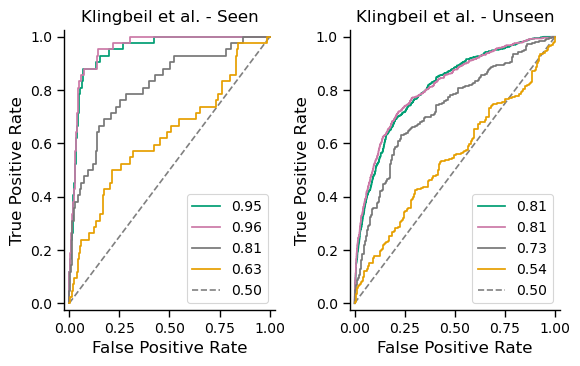

In [52]:
#dataset_names = ['Parrish et al. - Seen', 'Parrish et al. - Unseen', 'Klingbeil et al. - Seen', 'Klingbeil et al. - Unseen']
dataset_names = ['Klingbeil et al. - Seen', 'Klingbeil et al. - Unseen']
draw_validation_curves(validation_data_df[0:4], dataset_names)

In [53]:
def plot_pr_curve(ax, data, true_label, probas, label, color,
                  line_style="solid", draw_style="default", zorder=10,
                  labels_only=False, subplot_index=None):
    # Drop rows with NaNs in either column
    valid_data = data[[true_label, probas]].dropna()

    y_true = valid_data[true_label].values
    y_score = valid_data[probas].values

    # Skip if there aren't enough valid samples or variation in labels
    if len(y_true) < 2 or len(np.unique(y_true)) < 2:
        print(f"Skipping {label}: insufficient valid data.")
        return

    precision, recall, _ = precision_recall_curve(y_true, y_score)
    ap_score = average_precision_score(y_true, y_score)
    legend_label = f"{ap_score:.2f}"

    ax.plot(recall, precision, label=legend_label, color=color,
            linestyle=line_style, drawstyle=draw_style, zorder=zorder, linewidth=1.25)

    # Optional: annotate with X marker on a fixed point
    # if subplot_index in [2, 3]:
    #     ax.scatter(0.325, 0.4, color='red', marker="X", s=70, zorder=15)


def draw_pr_curves(data, true_labels, probas, labels, title, colors, ax, labels_only=False, subplot_index=None):
    for true_label, probas, label, color in zip(true_labels, probas, labels, colors):
        plot_pr_curve(ax, data, true_label, probas, label, color, labels_only=labels_only, subplot_index=subplot_index)

    no_skill = sum(data[true_labels[0]]) / len(data[true_labels[0]])
    ax.plot([0, 1], [no_skill, no_skill], linestyle='--', color='gray', label=f'{no_skill:.2f}')
    # ax.set_xlabel('Recall', fontsize=16)
    # ax.set_ylabel('Precision', fontsize=16)
    # ax.set_title(f'{title}', fontsize=14)
    # ax.tick_params(axis='x', labelsize=8)
    # ax.tick_params(axis='y', labelsize=8)
    # ax.spines.top.set(visible=False)
    # ax.spines.right.set(visible=False)
    # ax.set_ylim([-0.025, 1.025])
    # ax.set_xlim([-0.025, 1.025])
    # ax.legend(loc='upper right', fontsize=16)

    ax.set_xlabel('Recall', fontsize=12)
    ax.set_ylabel('Precision', fontsize=12)
    ax.set_title(f'{title}', fontsize=12)
    ax.tick_params(axis='x', labelsize=10)
    ax.tick_params(axis='y', labelsize=10)
    ax.spines.top.set(visible=False)
    ax.spines.right.set(visible=False)
    ax.set_ylim([-0.025, 1.025])
    ax.set_xlim([-0.025, 1.025])
    ax.legend(loc='upper right', fontsize=10)

def draw_pr_validation_curves(validation_data_df, title_list):
    sns.set_context('paper')
    fig, ax = plt.subplots(1, 2, figsize=(5.85, 3.75))

    true_labels = ['SL_early', 'SL_late', 'SL_early', 'SL_early']
    predictions = ['ypred_early', 'ypred_late', 'prediction_score', 'min_sequence_identity']
    custom_labels = ['Context-Specific Classifier (early)', 'Context-Specific Classifier (late)', 'General Classifier', 'Sequence Identity']
    colors = ['#009E73', '#CC79A7', '#777777', '#E69F00']

    for i, df in enumerate(validation_data_df):
        draw_pr_curves(df, true_labels, predictions, custom_labels, title_list[i], colors, ax[i], subplot_index=i)

    # Extract handles and labels from the first subplot
    handles, labels = ax[0].get_legend_handles_labels()
    
    # Create a shared legend for the figure
    #fig.legend(handles=handles, labels=custom_labels + ['Chance'], ncol=5, loc='upper center', 
    #           bbox_to_anchor=[0.5, 1.2], fontsize=20, fancybox=True, facecolor='#efefef', borderpad=0.5)

    #fig.legend(handles=handles, labels=custom_labels + ['Chance'], ncol=5, loc='upper center', 
    #           bbox_to_anchor=[0.5, 1.1], fontsize=10, fancybox=True, facecolor='#efefef', borderpad=0.5)

    plt.tight_layout(h_pad=0.5)
    plt.savefig(figure_path_pr_auc, bbox_inches='tight', dpi=500)
    #plt.close()
    #plt.show()

# Example usage
#dataset_names = ['CHyMErA screen', 'Dede et al.', 'Parrish et al.', 'Thompson et al.', 'Klingbeil et al.','Unseen Pairs']
#dataset_names = ['Parrish et al.', 'Klingbeil et al.', 'Unseen Pairs by Training Set', 'Seen Pairs - present in Trainig Set', 'All Pairs', 'All Pairs - excluding Barbara Data']
#draw_pr_validation_curves(validation_data_df, dataset_names, figure_path_pr_auc)

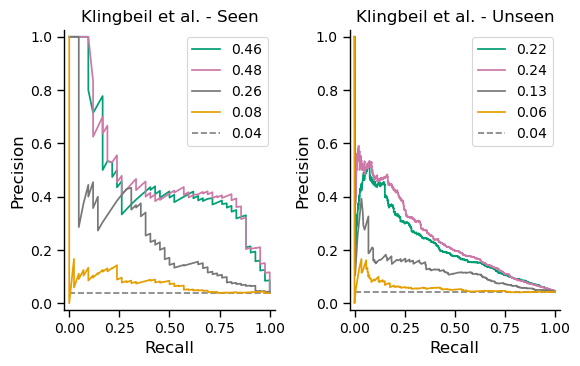

In [54]:
#dataset_names = ['Parrish et al. - Seen', 'Parrish et al. - Unseen', 'Klingbeil et al. - Seen', 'Klingbeil et al. - Unseen']
dataset_names = ['Klingbeil et al. - Seen', 'Klingbeil et al. - Unseen']
draw_pr_validation_curves(validation_data_df[0:4], dataset_names)